# Project Data Wrangling: Ecommerce Analysis

by DM Erdy Kusuma


## 1. Objective

Perusahaan ecommerce Olist Shop ingin menganalisa data yang dimiliki untuk mengembangkan performa bisnisnya. 

Manajemen meminta Divisi Data Analys untuk menjawab: 

1. Apa 10 kategori produk yang paling laris? 

2. Apa 10 negara dengan nilai transaksi tertinggi?

3. Apa 5 kategori produk yang paling banyak terjual di negara yang memiliki nilai transaksi tertinggi?

4. Bagaimana tren penjualan kategori produk yang paling tinggi nilai transaksi per bulannya?

5. Bagaimana tren penjualan per bulannya?



## 2. Data Overview

#### Data Olist memiliki 9 tabel:
1. olist_order_customer_dataset: data customers
2. olist_geolocation_dataset: data lokasi berdasarkan zipcode (kode pos)
3. olist_order_items_dataset: daftar item yang dibeli customer
4. olist_order_payments_dataset: data pembayaran
5. olist_order_reviews_dataset: data review dari customer
6. olist_order_dataset: data journey hingga status pemesanan
7. olist_products_dataset: data produk yang dijual
8. olist_sellers_dataset: data alamat seller
9. product_category_name_translation: terjemahan kategori produk berdasarkan bahasa Inggris/ Protugal 


In [57]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')


# Membuat koneksi dengan database
con = sqlite3.connect('olist.db')


In [27]:
# Memeriksa semua tabel beserta kolomnya
tables = con.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()

for table in tables:
    table_name = table[0]
    print(f"Tabel: {table_name}")
    
    # Baca tabel ke dalam DataFrame
    df = pd.read_sql_query(f"SELECT * FROM {table_name}", con)
    
    # Tampilkan tipe data kolom
    print("Kolom dan Tipe Data:")
    print(df.dtypes)
    print()



Tabel: olist_order_customer_dataset
Kolom dan Tipe Data:
index                        int64
customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object

Tabel: olist_order_dataset
Kolom dan Tipe Data:
index                             int64
order_id                         object
customer_id                      object
order_status                     object
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
dtype: object

Tabel: olist_order_reviews_dataset
Kolom dan Tipe Data:
index                       int64
review_id                  object
order_id                   object
review_score                int64
review_comment_title       object
review_comment_message     object
review_creation_date       object
r

In [28]:
# Mengangkases tabel yang diperlukan dan menyimpan ke dataframe

#data customer dan lokasi tinggal
query1 = """
SELECT * FROM olist_order_customer_dataset
"""
df_customer = pd.read_sql(query1, con)


#daftar rinci barang orderan per customer
query2 = """
SELECT * FROM olist_order_items_dataset
"""
df_order_itemlist = pd.read_sql(query2, con)


#data journey pemesanan hingga status pengiriman
query3 = """
SELECT * FROM olist_order_dataset
"""
df_order_process = pd.read_sql(query3, con)

#data kategori produk
query4 = """
SELECT * FROM olist_products_dataset
"""
df_product_category = pd.read_sql(query4, con)

#data geolocation
query5 = """
SELECT * FROM olist_geolocation_dataset
"""
df_geo = pd.read_sql(query5, con)

#data terjemahan
query6 = """
SELECT * FROM product_category_name_translation
"""
df_english = pd.read_sql(query6, con)



Berdasarkan objective yang dirumuskan dari permintaan perusahan, dataframe yang akan dimanfaatkan:
- df_customer
- df_order_itemlist
- df_order_process
- df_product_category
- df_english

## 3. Data Processing

In [29]:
#3.1 Cleaning tahap 1: menangani nan dan duplikat tiap tabel

#Mengidentifikasi nan

#df_customer
nan_col = df_customer.isna().sum().sort_values(ascending=False) / len(df_customer) * 100
contain_nan = pd.DataFrame(nan_col[nan_col > 0], columns = ["%nan"])
contain_nan



,%nan


In [30]:
# df_order_itemlist
nan_col = df_order_itemlist.isna().sum().sort_values(ascending=False) / len(df_order_itemlist) * 100
contain_nan = pd.DataFrame(nan_col[nan_col > 0], columns = ["%nan"])
contain_nan

,%nan


In [31]:
# df_geo
nan_col = df_geo.isna().sum().sort_values(ascending=False) / len(df_geo) * 100
contain_nan = pd.DataFrame(nan_col[nan_col > 0], columns = ["%nan"])
contain_nan

,%nan


In [32]:
# df_english
nan_col = df_english.isna().sum().sort_values(ascending=False) / len(df_english) * 100
contain_nan = pd.DataFrame(nan_col[nan_col > 0], columns = ["%nan"])
contain_nan


,%nan


In [33]:
# df_order_process
nan_col = df_order_process.isna().sum().sort_values(ascending=False) / len(df_order_process) * 100
contain_nan = pd.DataFrame(nan_col[nan_col > 0], columns = ["%nan"])
contain_nan

,%nan
order_delivered_customer_date,2.981668
order_delivered_carrier_date,1.793023
order_approved_at,0.160899


In [34]:
# df_order_process
#menghapus baris nan di kolom 
df_order_process.dropna(subset=['order_delivered_customer_date'], inplace=True)
df_order_process.dropna(subset=['order_delivered_carrier_date'], inplace=True)
df_order_process.dropna(subset=['order_approved_at'], inplace=True)

In [35]:
#memastikan jumlah data di semua kolom df_order_process sudah sama
df_order_process.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96461 entries, 0 to 99440
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   index                          96461 non-null  int64 
 1   order_id                       96461 non-null  object
 2   customer_id                    96461 non-null  object
 3   order_status                   96461 non-null  object
 4   order_purchase_timestamp       96461 non-null  object
 5   order_approved_at              96461 non-null  object
 6   order_delivered_carrier_date   96461 non-null  object
 7   order_delivered_customer_date  96461 non-null  object
 8   order_estimated_delivery_date  96461 non-null  object
dtypes: int64(1), object(8)
memory usage: 7.4+ MB


In [36]:
# df_product_category
nan_col = df_product_category.isna().sum().sort_values(ascending=False) / len(df_product_category) * 100
contain_nan = pd.DataFrame(nan_col[nan_col > 0], columns = ["%nan"])
contain_nan

df_product_category.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   index                       32951 non-null  int64  
 1   product_id                  32951 non-null  object 
 2   product_category_name       32341 non-null  object 
 3   product_name_lenght         32341 non-null  float64
 4   product_description_lenght  32341 non-null  float64
 5   product_photos_qty          32341 non-null  float64
 6   product_weight_g            32949 non-null  float64
 7   product_length_cm           32949 non-null  float64
 8   product_height_cm           32949 non-null  float64
 9   product_width_cm            32949 non-null  float64
dtypes: float64(7), int64(1), object(2)
memory usage: 2.5+ MB


In [37]:
# df_product_category
# mengisi nan di kolom bertipe object dengan "unknown"
df_product_category['product_category_name'].fillna('unknown', inplace=True)

# mengisi nan di kolom bertipe float dengan "median" 
df_product_category['product_name_lenght'].fillna(df_product_category['product_name_lenght'].median(), inplace=True)
df_product_category['product_description_lenght'].fillna(df_product_category['product_description_lenght'].median(),inplace=True)
df_product_category['product_photos_qty'].fillna(df_product_category['product_photos_qty'].median(),inplace=True)


In [38]:
# sisa nan di kolom lain akan kita hapus karena objective yang dirumuskan belum sampai menganalisa dimensi
drop_col = ['product_length_cm', 'product_height_cm', 'product_width_cm', 'product_weight_g']
df_product_category.drop(columns = drop_col, inplace=True)

df_product_category.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   index                       32951 non-null  int64  
 1   product_id                  32951 non-null  object 
 2   product_category_name       32951 non-null  object 
 3   product_name_lenght         32951 non-null  float64
 4   product_description_lenght  32951 non-null  float64
 5   product_photos_qty          32951 non-null  float64
dtypes: float64(3), int64(1), object(2)
memory usage: 1.5+ MB


In [39]:
# menghapus duplikasi di semua kolom tabel
# cek duplikasi: df_customer.duplicated().any()

df_customer.drop_duplicates(keep='first',inplace=True, ignore_index=True)
df_order_itemlist.drop_duplicates(keep='first',inplace=True, ignore_index=True)
df_order_process.drop_duplicates(keep='first',inplace=True, ignore_index=True)
df_product_category.drop_duplicates(keep='first',inplace=True, ignore_index=True)
df_geo.drop_duplicates(keep='first',inplace=True, ignore_index=True)
df_english.drop_duplicates(keep='first',inplace=True, ignore_index=True)



In [40]:
#3.2 Combining: menggabungkan tabel yang digunakan
# df_customer
# df_order_itemlist
# df_order_process
# df_product_category
# df_geo
# df_english

# (df_order_itemlist + df_order_process) + (df_product_category + df_english) + df_customer
dfmerge_order = pd.merge(df_order_process, df_order_itemlist, on='order_id')
dfmerge_category = pd.merge(df_product_category, df_english, on='product_category_name')
dfmerge_order_category = pd.merge(dfmerge_order, dfmerge_category, on='product_id')

dfmerge_order_category_customer = pd.merge(dfmerge_order_category, df_customer, on='customer_id')
df_olist = dfmerge_order_category_customer



In [41]:
df_olist.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108622 entries, 0 to 108621
Data columns (total 28 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   index_x_x                      108622 non-null  int64  
 1   order_id                       108622 non-null  object 
 2   customer_id                    108622 non-null  object 
 3   order_status                   108622 non-null  object 
 4   order_purchase_timestamp       108622 non-null  object 
 5   order_approved_at              108622 non-null  object 
 6   order_delivered_carrier_date   108622 non-null  object 
 7   order_delivered_customer_date  108622 non-null  object 
 8   order_estimated_delivery_date  108622 non-null  object 
 9   index_y_x                      108622 non-null  int64  
 10  order_item_id                  108622 non-null  int64  
 11  product_id                     108622 non-null  object 
 12  seller_id                     

In [42]:
# membuang kolom yang tidak kita perlukan untuk menjawab objective
drop_index = [
    'index_x_x', 'index_x_y','index_y_x', 'index_y_y', 'order_delivered_carrier_date',
    'order_delivered_customer_date','order_estimated_delivery_date','shipping_limit_date',
    'product_name_lenght', 'product_description_lenght', 'product_photos_qty',  'freight_value', 
    'product_category_name', 'customer_unique_id', 'customer_zip_code_prefix'
]
df_olist = df_olist.drop(columns = drop_index )
df_olist.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_item_id,product_id,seller_id,price,product_category_name_english,index,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,housewares,70296,sao paulo,SP
1,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,housewares,45300,sao paulo,SP
2,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,housewares,57439,sao paulo,SP
3,bfc39df4f36c3693ff3b63fcbea9e90a,53904ddbea91e1e92b2b3f1d09a7af86,delivered,2017-10-23 23:26:46,2017-10-25 02:14:11,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,housewares,91460,florianopolis,SC
4,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,118.70,perfumery,77027,barreiras,BA


In [44]:
# Menangani tipe data kolom yang tidak representatif
# mengubah tipe data objet menjadi datetime pada kolom yang menerangkan waktu

# Ubah kolom 'order_purchase_timestamp' dan 'order_approved' menjadi datetime
df_olist['order_purchase_timestamp'] = pd.to_datetime(df_olist['order_purchase_timestamp'], yearfirst=True)
df_olist['order_approved_at'] = pd.to_datetime(df_olist['order_approved_at'], yearfirst=True)

df_olist.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108622 entries, 0 to 108621
Data columns (total 13 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       108622 non-null  object        
 1   customer_id                    108622 non-null  object        
 2   order_status                   108622 non-null  object        
 3   order_purchase_timestamp       108622 non-null  datetime64[ns]
 4   order_approved_at              108622 non-null  datetime64[ns]
 5   order_item_id                  108622 non-null  int64         
 6   product_id                     108622 non-null  object        
 7   seller_id                      108622 non-null  object        
 8   price                          108622 non-null  float64       
 9   product_category_name_english  108622 non-null  object        
 10  index                          108622 non-null  int64         
 11  

In [45]:
# mengecek lagi apakah ada nan
df_olist.isna().any()

order_id                         False
customer_id                      False
order_status                     False
order_purchase_timestamp         False
order_approved_at                False
order_item_id                    False
product_id                       False
seller_id                        False
price                            False
product_category_name_english    False
index                            False
customer_city                    False
customer_state                   False
dtype: bool

In [46]:
# Mengidentifikasi outlier
df_olist.describe().T

,count,mean,std,min,25%,50%,75%,max
order_item_id,108622.0,1.198643,0.708592,1.00,1.00,1.0,1.0,21.0
price,108622.0,120.078147,182.071976,0.85,39.90,74.9,134.9,6735.0
index,108622.0,49738.648837,28702.261512,0.00,24896.25,49761.5,74547.0,99440.0


<Axes: xlabel='price'>

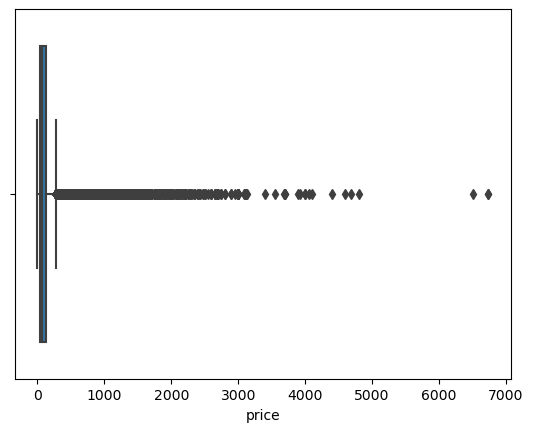

In [47]:
# Sekilas terlihat nilai maksimum price jauh melebihi quartil 3 
# Kita cek lagi dengan boxplot
import seaborn as sns
sns.boxplot(data=df_olist,x="price")


<Axes: xlabel='price'>

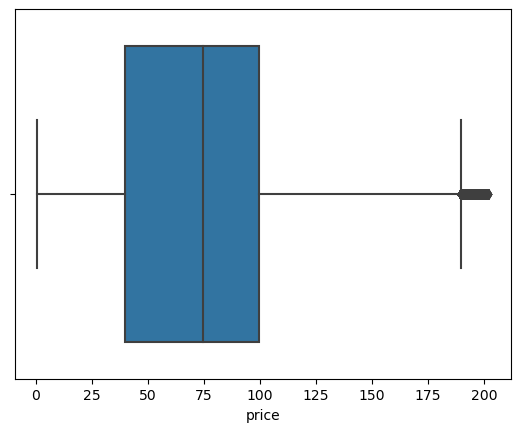

In [48]:
# Menangani outlier price

# nilai terkecil dari price bukan nol, jadi langsung ke tahap outlier 
batas_atas = df_olist["price"].quantile(q=0.75) * 1.5

# Mencari nilai median
med = df_olist["price"].median()

# mengubah nilai outlier dengan median
df_olist.loc[df_olist["price"] > batas_atas, "price"]= med
sns.boxplot(data=df_olist,x="price")

## 4. Analisys & Visualization


Setelah data sudah bersih, selanjutnya menjawab objective yang dirumuskan:

1. Apa 10 kategori produk yang paling laris? 

2. Apa 10 negara dengan nilai transaksi tertinggi?

3. Apa 5 kategori produk yang paling banyak terjual di negara yang memiliki nilai transaksi tertinggi?

4. Bagaimana tren penjualan kategori produk yang paling tinggi nilai transaksi per bulannya?

5. Bagaimana tren penjualan per bulannya?

In [49]:
# 1. 10 kategori produk dengan transaksi penjualan tertinggi
top_sales_by_category = df_olist.groupby('product_category_name_english')['price'].sum().head(10).sort_values(ascending=False)
top_sales_by_category = top_sales_by_category.rename_axis('Top 10 Sales by Product Category')
top_sales_by_category

Top 10 Sales by Product Category
bed_bath_table                874682.83
auto                          328444.38
baby                          235869.96
books_general_interest         34174.05
air_conditioning               30001.35
audio                          27653.14
art                            16494.91
agro_industry_and_commerce     13340.04
books_imported                  3744.76
arts_and_craftmanship           1436.32
Name: price, dtype: float64

In [52]:
# 2. 10 asal negara customer dengan nilai transaksi tertinggi 
top_city = df_olist.groupby('customer_state')['price'].sum().head(10).sort_values(ascending=False)
top_city = top_city.rename_axis('Top 10 Sales by Customer State')
top_city


Top 10 Sales by Customer State
BA    288684.74
DF    181324.09
ES    174145.36
GO    171192.18
CE    113865.28
MA     63411.50
AL     35735.37
AM     12781.95
AC      7934.25
AP      7342.68
Name: price, dtype: float64

In [54]:
# 3. 5 kategori produk yang paling banyak terjual di negara dengan transaksi tertinggi
# Filter data hanya untuk negara bagian berkode BA (Bosnia and Herzegovina)
BA_state = df_olist[df_olist['customer_state'] == 'BA']
top_product_in_state = BA_state['product_category_name_english'].value_counts().head(5)
print(top_product_in_state)


health_beauty            340
sports_leisure           286
bed_bath_table           254
computers_accessories    250
furniture_decor          247
Name: product_category_name_english, dtype: int64


In [60]:

# Mengekstraksi informasi tanggal dari kolom order_purchase_timestamp
df_olist['month'] = df_olist['order_purchase_timestamp'].dt.strftime('%Y-%m')
df_olist['year'] = df_olist['order_purchase_timestamp'].dt.year



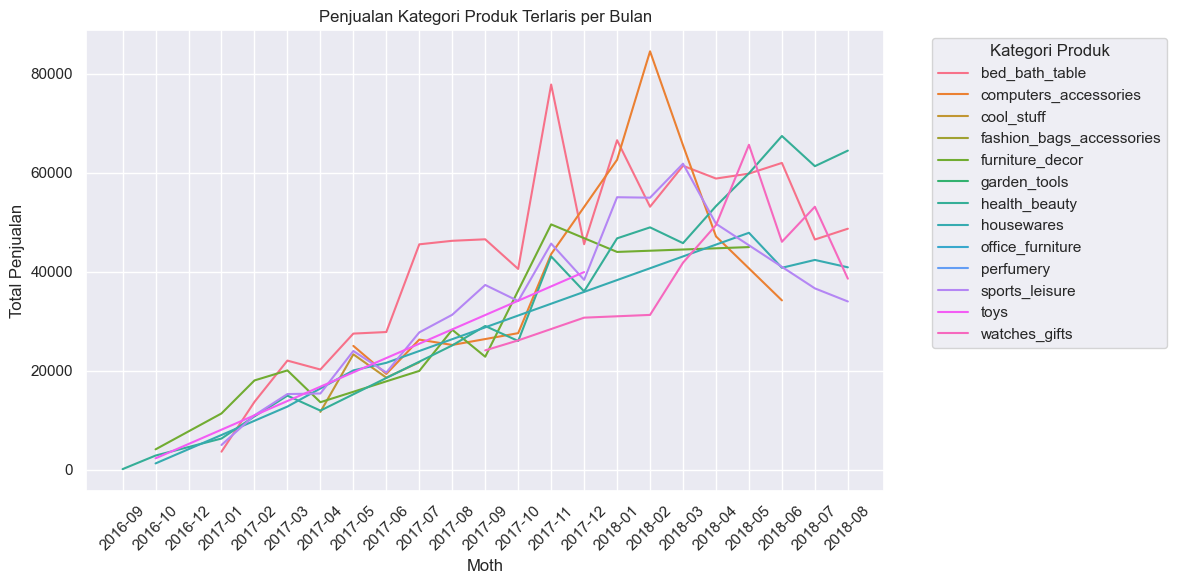

In [71]:
# 4. 5 kategori produk dengan penjualan teratas per bulannya

pivot_table = df_olist.groupby(['month', 'product_category_name_english'])['price'].sum().reset_index()

# Mengurutkan nilai berdasarkan month dan total price dari besar ke kecil
pivot_table = pivot_table.sort_values(by=['month', 'price'], ascending=[True, False])

# Mengambil 10 kategori produk terlaris untuk setiap bulan
top_5_categories = pivot_table.groupby('month').head(5)

# Membuat tabel pivot dengan indeks 'month', kolom 'product_category_name_english', dan nilai 'price'
pivot_table = top_5_categories.pivot(index='month', columns='product_category_name_english', values='price')


sns.set(style="darkgrid")

# Membuat plot garis dengan Seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(data=pivot_table, dashes=False)
plt.title('Penjualan Kategori Produk Terlaris per Bulan')
plt.xlabel('Moth')
plt.ylabel('Total Penjualan')
plt.xticks(rotation=45)
plt.legend(title='Kategori Produk', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()

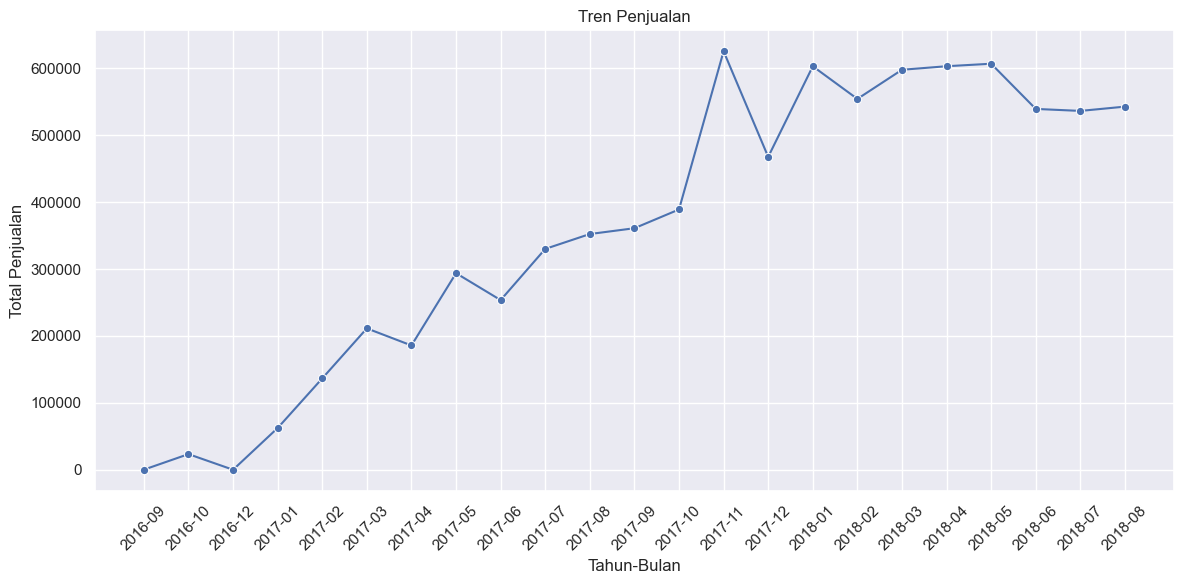

In [67]:
# 5 Tren Penjualan
# Membuat tabel pivot dengan indeks 'month', kolom 'product_category_name_english', dan nilai 'price'
monthly_sales = df_olist.groupby('month')['price'].sum().reset_index()

# Mengatur gaya plot Seaborn
sns.set(style="darkgrid")

# Membuat plot garis dengan Seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_sales, x='month', y='price', marker='o')
plt.title('Tren Penjualan')
plt.xlabel('Tahun-Bulan')
plt.ylabel('Total Penjualan')
plt.xticks(rotation=45)
plt.tight_layout()

# Menampilkan grafik
plt.show()

## 5. Conclusion

- Kateori produk bed_bath_table menjadi produk yang memberi nilai penjualan tertinggi sepanjang waktu. 
- Negara berkode BA (Bosnia and Herzegovina) menjadi negara asal customer yang memiliki transaksi tertinggi.
- Kaegori produk yang paling laris di negara BA adalah health_beauty, jadi promosi produk ini bisa terus digencarkan.
- Dari grafik tren penjualan per kategory, terlihat bahwa kategori toys, sport_leisure, dan computer mengalami penurunan.

Secara umum, tren penjualan cenderung stagnan dan menurun sejak November 2017. Perlu ada upaya lebih lanjut untuk meningkat pertumbuhan.